In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 922.4 kB/s eta 0:00:00


In [4]:
import os

os.chdir('/content/drive/MyDrive/Human Data Analytics/Project')

In [5]:
import tqdm
from parameters import *
import librosa
from utils import *

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split


In [7]:
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))
# rates = np.random.randint(1,50,len(x_train))/10000

def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))
# rates = np.random.choice(np.arange(2,6),len(y_train))

def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate = rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")
# rates = np.random.choice(np.arange(80,120),len(y_train))/100

In [8]:
audio_list = []
target_list = []

METADATA_FILE_PATH = '/content/drive/MyDrive/Human Data Analytics/Project/Data/ESC-50-master/ESC-50-master/meta/esc50.csv'
AUDIO_FOLDER = '/content/drive/MyDrive/Human Data Analytics/Project/Data/ESC-50-master/ESC-50-master/audio/'

df = import_dataframe(METADATA_FILE_PATH, which_dataset='esc10')

data = []

for filename,target in tqdm(list(zip(df['filename'], df['target'])), desc = 'Importing dataset'):
        y, fs = librosa.load(AUDIO_FOLDER + filename, sr=SR)
        data.append((y,target))

audio_data = []
labels=[]

for i,j in data:
    audio_data.append(i)
    labels.append(j)

audio_data=np.array(audio_data) # array with size (n_data, n_samples). Each row contains an audio
labels=np.array(labels) # array with size (n_data), contains the indexes of the labels

import keras
ylabels=keras.utils.to_categorical(labels, num_classes=OUTPUT_CLASSES, dtype='float32')

from skimage import util

sub_sequence= SR*1.25    #  1.25 seconds of signal !
st=400 #  samples for sliding the window ith overlap
X_train_red = []
X_test_red = []
train_labels_final = []

X_train, X_test, y_train, y_test = train_test_split(audio_data, labels, test_size=0.2, random_state=42)
# (train_images, train_labels), (test_images, test_labels) = (X_train, y_train), (X_test, y_test)

# train_images = np.array(train_images)
# test_images = np.array(test_images)

for i in tqdm(range(0, len(X_train)), desc='data reduction'):
    frames = util.view_as_windows(X_train[i], window_shape=(sub_sequence,), step=st)
    frame_intensity = []

    for frame in frames:
        frame_intensity.append(frame @ frame)

    optim_frame_index = np.array(frame_intensity).argmax()
    final_frame = frames[optim_frame_index] / np.max(frames[optim_frame_index])

    # Determine the probability interval
    probability = np.random.rand()

    # Adjust these probabilities according to your preference
    if probability < 0.35:
        # Apply white noise
        altered_frame = add_white_noise(final_frame)
        X_train_red.append(altered_frame)
        train_labels_final.append(y_train[i])
    elif 0.25 <= probability < 0.75:
        # Shift the sound
        altered_frame = shift_sound(final_frame)
        X_train_red.append(altered_frame)
        train_labels_final.append(y_train[i])
    elif 0.5 <= probability < 0.95:
        # Stretch the sound
        altered_frame = stretch_sound(final_frame)
        X_train_red.append(altered_frame)
        train_labels_final.append(y_train[i])

    X_train_red.append(final_frame)
    train_labels_final.append(y_train[i])


for i in tqdm(range(0, len(X_test)), desc='data reduction'):
    frames = util.view_as_windows(X_test[i], window_shape=(sub_sequence,), step=st)
    frame_intensity = []

    for frame in frames:
        frame_intensity.append(frame @ frame)

    optim_frame_index = np.array(frame_intensity).argmax()
    final_frame = frames[optim_frame_index] / np.max(frames[optim_frame_index])

    X_test_red.append(final_frame)

data reduction: 100%|██████████| 80/80 [00:00<00:00, 963.68it/s]


In [9]:
def compute_spectrograms(audio_data_list, sr=SR, n_fft=2048, hop_length=512):
    spectrogram_list = []

    for audio_data in audio_data_list:
        # Compute the short-time Fourier transform (STFT)
        stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)

        # Convert magnitude spectrogram to decibels (log scale)
        spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

        # Append the spectrogram to the list
        spectrogram_list.append(spectrogram)

    return spectrogram_list

def plot_spectrogram(spectrogram, sr=22050, hop_length=512):
    # Convert time to seconds
    times = librosa.times_like(spectrogram, sr=sr, hop_length=hop_length)

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

In [10]:
train_spectrograms_before = compute_spectrograms(X_train_red, sr=SR, n_fft=2048, hop_length=256)
test_spectrograms = compute_spectrograms(X_test_red, sr=SR, n_fft=2048, hop_length=256)

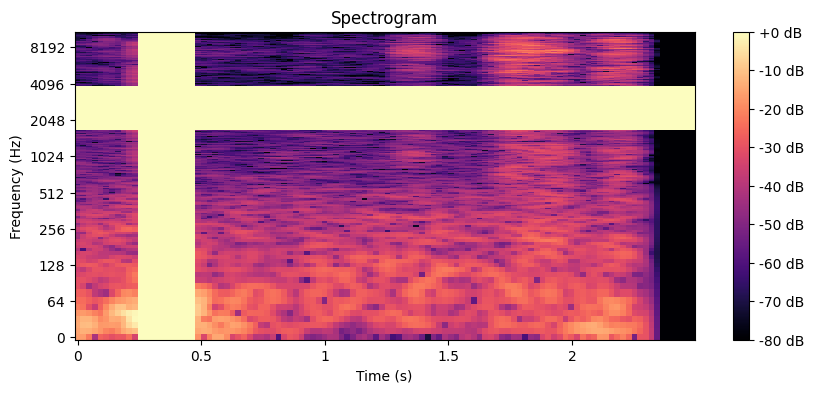

In [11]:
def apply_frequency_masking(spec, max_mask_percentage=0.1):
    num_freq_bins = spec.shape[1]
    max_mask_bins = int(max_mask_percentage * num_freq_bins)
    mask_start = np.random.randint(0, num_freq_bins - max_mask_bins)
    mask_end = mask_start + max_mask_bins
    masked_spec = spec.copy()
    masked_spec[:, mask_start:mask_end] = 0.0
    return masked_spec

def apply_time_masking(spec, max_mask_percentage=0.2):
    num_time_frames = spec.shape[0]
    max_mask_frames = int(max_mask_percentage * num_time_frames)
    mask_start = np.random.randint(0, num_time_frames - max_mask_frames)
    mask_end = mask_start + max_mask_frames
    masked_spec = spec.copy()
    masked_spec[mask_start:mask_end, :] = 0.0
    return masked_spec

def augment_spectrogram(spec):
    spec = apply_frequency_masking(spec)
    spec = apply_time_masking(spec)
    return spec

plot_spectrogram(augment_spectrogram(train_spectrograms_before[0]))

train_labels_final_augment = []
train_spectrograms = []

for i, spect in enumerate(train_spectrograms_before):
  probability = np.random.rand()

  if probability <= 0.5:
    train_spectrograms.append(augment_spectrogram(spect))
    train_labels_final_augment.append(train_labels_final[i])
  elif probability >= 0.3 and probability <= 0.8:
    train_spectrograms.append(augment_spectrogram(spect))
    train_labels_final_augment.append(train_labels_final[i])

  train_spectrograms.append(spect)
  train_labels_final_augment.append(train_labels_final[i])


In [14]:
X_train, X_test, y_train, y_test = train_test_split(audio_data_red, labels, test_size=0.4, random_state=42)

# Create a tf.data.Dataset from the lists
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Define a function to convert audio and label to spectrogram and label
def map_func(audio, label):
    spectrogram = get_spectrogram(audio)
    return spectrogram, label

# Apply the map function to the dataset
train_dataset = train_dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Print the first element in the dataset (for testing purposes)
for spec, label in train_dataset.take(1):
    print("Spectrogram shape:", spec.shape)
    print("Label:", label)

def example_spectrogram():
  for spec, label in train_dataset.take(1):
    return spec.shape

NameError: name 'audio_data_red' is not defined

In [ ]:
for example_spectrograms, example_spect_labels in train_dataset.take(1):
  break

In [15]:
import math

import six
from einops.layers.tensorflow import Rearrange
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import datasets

import logging
import numpy as np

from fastprogress import master_bar, progress_bar

In [16]:
def gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh(
        (math.sqrt(2 / math.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf


def get_activation(identifier):
    """Maps a identifier to a Python function, e.g., "relu" => `tf.nn.relu`.
    It checks string first and if it is one of customized activation not in TF,
    the corresponding activation will be returned. For non-customized activation
    names and callable identifiers, always fallback to tf.keras.activations.get.
    Args:
        identifier: String name of the activation function or callable.
    Returns:
        A Python function corresponding to the activation function.
    """
    if isinstance(identifier, six.string_types):
        name_to_fn = {"gelu": gelu}
        identifier = str(identifier).lower()
        if identifier in name_to_fn:
            return tf.keras.activations.get(name_to_fn[identifier])
    return tf.keras.activations.get(identifier)


class Residual(tf.keras.Model):

    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x


class PreNorm(tf.keras.Model):

    def __init__(self, dim, fn):
        super().__init__()
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-5)
        self.fn = fn

    def call(self, x):
        return self.fn(self.norm(x))


class FeedForward(tf.keras.Model):

    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation=get_activation('gelu'),
                                                              kernel_regularizer=tf.keras.regularizers.l2(1e-1)),
                                        tf.keras.layers.Dense(hidden_dim, activation=get_activation('gelu'),
                                                              kernel_regularizer=tf.keras.regularizers.l2(1e-1)),
                                        tf.keras.layers.Dense(dim, kernel_regularizer=tf.keras.regularizers.l2(1e-2))])

    def call(self, x):
        return self.net(x)

class Attention(tf.keras.Model):

    def __init__(self, dim, heads = 8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = tf.keras.layers.Dense(dim * 3, use_bias=False)
        self.to_out = tf.keras.layers.Dense(dim)

        self.rearrange_qkv = Rearrange('b n (qkv h d) -> qkv b h n d', qkv = 3, h = self.heads)
        self.rearrange_out = Rearrange('b h n d -> b n (h d)')

    def call(self, x):
        qkv = self.to_qkv(x)
        qkv = self.rearrange_qkv(qkv)
        q = qkv[0]
        k = qkv[1]
        v = qkv[2]

        dots = tf.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = tf.nn.softmax(dots,axis=-1)

        out = tf.einsum('bhij,bhjd->bhid', attn, v)
        out = self.rearrange_out(out)
        out =  self.to_out(out)
        return out

class Transformer(tf.keras.Model):

    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.extend([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ])
        self.net = tf.keras.Sequential(layers)

    def call(self, x):
        return self.net(x)

class ViT(tf.keras.Model):

    def __init__(self, *, image_height, image_width, patch_size_height, patch_size_width, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_height % patch_size_height == 0, 'image dimensions must be divisible by the patch size'
        num_patches = num_patches = (image_height // patch_size_height) * (image_width // patch_size_width)
        patch_dim = channels * patch_size_height * patch_size_width

        self.patch_size_height = patch_size_height
        self.patch_size_width = patch_size_width
        self.dim = dim
        self.pos_embedding = self.add_weight("position_embeddings",
                                             shape=[num_patches + 1,
                                                    dim],
                                             initializer=tf.keras.initializers.RandomNormal(),
                                             dtype=tf.float32)
        self.patch_to_embedding = tf.keras.layers.Dense(dim)
        self.cls_token = self.add_weight("cls_token",
                                         shape=[1,
                                                1,
                                                dim],
                                         initializer=tf.keras.initializers.RandomNormal(),
                                         dtype=tf.float32)

        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size_height, p2=self.patch_size_width)

        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = tf.identity

        self.mlp_head = tf.keras.Sequential([tf.keras.layers.Dense(mlp_dim, activation=get_activation('gelu'),
                                                                   kernel_regularizer=tf.keras.regularizers.l2(1e-1)),
                                             tf.keras.layers.Dense(mlp_dim, activation=get_activation('gelu'),
                                                                   kernel_regularizer=tf.keras.regularizers.l2(1e-1)),
                                        tf.keras.layers.Dense(num_classes,
                                                              kernel_regularizer=tf.keras.regularizers.l2(1e-2))])

    @tf.function
    def call(self, img):
        shapes = tf.shape(img)

        x = self.rearrange(img)
        x = self.patch_to_embedding(x)

        cls_tokens = tf.broadcast_to(self.cls_token,(shapes[0],1,self.dim))
        x = tf.concat((cls_tokens, x), axis=1)
        x += self.pos_embedding
        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [17]:
logger = logging.getLogger(__name__)


class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 1e-3
    # checkpoint settings
    ckpt_path = None

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

In [18]:
class Trainer:

    def __init__(self, model, model_config, train_dataset, train_dataset_len, test_dataset, test_dataset_len, config):
        self.train_dataset = train_dataset.batch(config.batch_size)
        self.train_dataset_len = train_dataset_len
        self.test_dataset = test_dataset
        self.test_dataset_len = None
        self.test_dist_dataset = None
        if self.test_dataset:
            self.test_dataset = test_dataset.batch(config.batch_size)
            self.test_dataset_len = test_dataset_len
        self.config = config
        self.tokens = 0
        self.strategy = tf.distribute.OneDeviceStrategy("GPU:0")
        if len(tf.config.list_physical_devices('GPU')) > 1:
            self.strategy = tf.distribute.MirroredStrategy()

        with self.strategy.scope():
            self.model = model(**model_config)
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
            self.cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
            self.train_dist_dataset = self.strategy.experimental_distribute_dataset(self.train_dataset)
            if self.test_dataset:
                self.test_dist_dataset = self.strategy.experimental_distribute_dataset(self.test_dataset)

    def save_checkpoints(self):
        if self.config.ckpt_path is not None:
            self.model.save_weights(self.config.ckpt_path)


    def train(self):

        train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
        test_loss_metric = tf.keras.metrics.Mean('testing_loss', dtype=tf.float32)

        train_accuracy = tf.keras.metrics.Accuracy('training_accuracy', dtype=tf.float32)
        test_accuracy = tf.keras.metrics.Accuracy('testing_accuracy', dtype=tf.float32)

        @tf.function
        def train_step(dist_inputs):

            def augment_data(X, Y):
                # Random left-right flip
                X = tf.image.random_flip_left_right(X)

                return X, Y

            def step_fn(inputs):

                X, Y = inputs

                # Probability for data augmentation
                augmentation_probability = 0.5  # Adjust this probability as needed

                # Apply data augmentation with a certain probability
                should_augment = tf.random.uniform([]) < augmentation_probability

                # if should_augment:
                #     X, Y = augment_data(X, Y)

                with tf.GradientTape() as tape:
                # training=True is only needed if there are layers with different
                # behavior during training versus inference (e.g. Dropout).
                    logits = self.model(X,training=True)
                    num_labels = tf.shape(logits)[-1]
                    label_mask = tf.math.logical_not(Y < 0)
                    label_mask = tf.reshape(label_mask,(-1,))
                    logits = tf.reshape(logits,(-1,num_labels))
                    logits_masked = tf.boolean_mask(logits,label_mask)
                    label_ids = tf.reshape(Y,(-1,))
                    label_ids_masked = tf.boolean_mask(label_ids,label_mask)
                    cross_entropy = self.cce(label_ids_masked, logits_masked)
                    loss = tf.reduce_sum(cross_entropy) * (1.0 / self.config.batch_size)
                    y_pred = tf.argmax(tf.nn.softmax(logits,axis=-1),axis=-1)
                    train_accuracy.update_state(tf.squeeze(Y),y_pred)

                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(list(zip(grads, self.model.trainable_variables)))
                return cross_entropy

            per_example_losses = self.strategy.run(step_fn, args=(dist_inputs,))
            sum_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_example_losses, axis=0)
            mean_loss = sum_loss / self.config.batch_size
            return mean_loss

        @tf.function
        def test_step(dist_inputs):

            def step_fn(inputs):

                X, Y = inputs
                # training=True is only needed if there are layers with different
                # behavior during training versus inference (e.g. Dropout).
                logits = self.model(X,training=False)
                num_labels = tf.shape(logits)[-1]
                label_mask = tf.math.logical_not(Y < 0)
                label_mask = tf.reshape(label_mask,(-1,))
                logits = tf.reshape(logits,(-1,num_labels))
                logits_masked = tf.boolean_mask(logits,label_mask)
                label_ids = tf.reshape(Y,(-1,))
                label_ids_masked = tf.boolean_mask(label_ids,label_mask)
                cross_entropy = self.cce(label_ids_masked, logits_masked)
                loss = tf.reduce_sum(cross_entropy) * (1.0 / self.config.batch_size)
                y_pred = tf.argmax(tf.nn.softmax(logits,axis=-1),axis=-1)
                test_accuracy.update_state(tf.squeeze(Y),y_pred)

                return cross_entropy

            per_example_losses = self.strategy.run(step_fn, args=(dist_inputs,))
            sum_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_example_losses, axis=0)
            mean_loss = sum_loss / self.config.batch_size
            return mean_loss

        train_pb_max_len = math.ceil(float(self.train_dataset_len)/float(self.config.batch_size))
        test_pb_max_len = math.ceil(float(self.test_dataset_len)/float(self.config.batch_size)) if self.test_dataset else None

        epoch_bar = master_bar(range(self.config.max_epochs))
        with self.strategy.scope():
            for epoch in epoch_bar:
                for inputs in progress_bar(self.train_dist_dataset,total=train_pb_max_len,parent=epoch_bar):
                    loss = train_step(inputs)
                    self.tokens += tf.reduce_sum(tf.cast(inputs[1]>=0,tf.int32)).numpy()
                    train_loss_metric(loss)
                    epoch_bar.child.comment = f'training loss : {train_loss_metric.result()}'
                print(f"epoch {epoch+1}: train loss {train_loss_metric.result():.5f}. train accuracy {train_accuracy.result():.5f}")
                train_loss_metric.reset_states()
                train_accuracy.reset_states()

                if self.test_dist_dataset:
                    for inputs in progress_bar(self.test_dist_dataset,total=test_pb_max_len,parent=epoch_bar):
                        loss = test_step(inputs)
                        test_loss_metric(loss)
                        epoch_bar.child.comment = f'testing loss : {test_loss_metric.result()}'
                    print(f"epoch {epoch+1}: val loss {test_loss_metric.result():.5f}. val accuracy {test_accuracy.result():.5f}")
                    test_loss_metric.reset_states()
                    test_accuracy.reset_states()

                self.save_checkpoints()

In [19]:
len(train_spectrograms)

1128

In [20]:
X_train, X_val, y_train, y_val = train_test_split(train_spectrograms_before, train_labels_final, test_size=0.1, random_state=42)
(train_images, train_labels), (val_images, val_labels) = (X_train, y_train), (X_val, y_val)

test_labels = y_test

train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_spectrograms)

In [21]:
val_images[10].shape

(1025, 108)

In [22]:
train_images = tf.cast(train_images.reshape((-1, 1, 1025, 108)),dtype=tf.float32)
val_images = tf.cast(val_images.reshape((-1, 1, 1025, 108)),dtype=tf.float32)
test_images = tf.cast(test_images.reshape((-1, 1, 1025, 108)),dtype=tf.float32)
train_images, test_images, val_images = train_images / 80.0, test_images / 80.0, val_images / 80.0

In [23]:
train_x = tf.data.Dataset.from_tensor_slices(train_images)
train_y = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset = tf.data.Dataset.zip((train_x,train_y))

val_x = tf.data.Dataset.from_tensor_slices(val_images)
val_y = tf.data.Dataset.from_tensor_slices(val_labels)
val_dataset = tf.data.Dataset.zip((val_x,val_y))

test_x = tf.data.Dataset.from_tensor_slices(test_images)
test_y = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset = tf.data.Dataset.zip((test_x,test_y))

In [24]:
total_number_of_examples = len(train_images)
batch_size = 64
epochs_for_decay = 40

steps_per_epoch = total_number_of_examples // batch_size
decay_steps = epochs_for_decay * steps_per_epoch
print(decay_steps)

initial_learning_rate = 1e-3  # Adjust this to your preferred initial learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,  # Adjust the decay steps according to your training schedule
    decay_rate=0.7,  # Adjust the decay rate
    staircase=False  # Set to True for staircase decay, False for continuous decay
)

tconf = TrainerConfig(max_epochs=120, batch_size=64, learning_rate=lr_schedule)


320


In [26]:
model_config = {"image_height":1025,
                "image_width": 108,
                "patch_size_height":205,
                "patch_size_width":12,
                "num_classes":10,
                "dim":64,
                "depth":30,
                "heads":16,
                "mlp_dim":128}

In [27]:
trainer = Trainer(ViT, model_config, train_dataset, len(train_images), val_dataset, len(val_images), tconf)

In [28]:
trainer.train()

epoch 1: train loss 3.95948. train accuracy 0.13121
epoch 1: val loss 3.03402. val accuracy 0.15873
epoch 2: train loss 2.51377. train accuracy 0.13121
epoch 2: val loss 2.35312. val accuracy 0.17460
epoch 3: train loss 2.26314. train accuracy 0.15071
epoch 3: val loss 2.21481. val accuracy 0.19048
epoch 4: train loss 2.04422. train accuracy 0.19858
epoch 4: val loss 2.10075. val accuracy 0.19048
epoch 5: train loss 1.96101. train accuracy 0.20922
epoch 5: val loss 2.00763. val accuracy 0.15873
epoch 6: train loss 1.92959. train accuracy 0.21809
epoch 6: val loss 1.91770. val accuracy 0.23810
epoch 7: train loss 1.98063. train accuracy 0.22340
epoch 7: val loss 1.95683. val accuracy 0.20635
epoch 8: train loss 1.92852. train accuracy 0.22340
epoch 8: val loss 2.00412. val accuracy 0.23810
epoch 9: train loss 1.86831. train accuracy 0.24468
epoch 9: val loss 1.94903. val accuracy 0.25397
epoch 10: train loss 1.85806. train accuracy 0.21986
epoch 10: val loss 1.89186. val accuracy 0.2381

In [29]:
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def test_model(trainer, test_dataset, test_dataset_len):
    test_loss_metric = tf.keras.metrics.Mean('testing_loss', dtype=tf.float32)

    @tf.function
    def test_step(dist_inputs):
        def step_fn(inputs):
            X, Y = inputs
            logits = trainer.model(X, training=False)
            num_labels = tf.shape(logits)[-1]
            label_mask = tf.math.logical_not(Y < 0)
            label_mask = tf.reshape(label_mask, (-1,))
            logits = tf.reshape(logits, (-1, num_labels))
            logits_masked = tf.boolean_mask(logits, label_mask)
            label_ids = tf.reshape(Y, (-1,))
            label_ids_masked = tf.boolean_mask(label_ids, label_mask)
            cross_entropy = trainer.cce(label_ids_masked, logits_masked)

            return {'loss': cross_entropy, 'predictions': tf.argmax(tf.nn.softmax(logits, axis=-1), axis=-1), 'labels': tf.squeeze(Y)}

        per_example_info = trainer.strategy.run(step_fn, args=(dist_inputs,))
        return per_example_info

    test_dist_dataset = trainer.strategy.experimental_distribute_dataset(test_dataset.batch(trainer.config.batch_size))
    test_pb_max_len = math.ceil(float(test_dataset_len) / float(trainer.config.batch_size))

    all_predictions = {'loss': [], 'predictions': [], 'labels': []}

    # Measure time for the entire test set
    start_time = time.time()

    for inputs in progress_bar(test_dist_dataset, total=test_pb_max_len, parent=None):
        batch_info = test_step(inputs)

        all_predictions['loss'].append(batch_info['loss'])
        all_predictions['predictions'].append(batch_info['predictions'])
        all_predictions['labels'].append(batch_info['labels'])

    end_time = time.time()

    # Concatenate the lists
    all_predictions['loss'] = tf.concat(all_predictions['loss'], axis=0)
    all_predictions['predictions'] = tf.concat(all_predictions['predictions'], axis=0)
    all_predictions['labels'] = tf.concat(all_predictions['labels'], axis=0)

    # Compute metrics
    test_loss_metric(tf.reduce_sum(all_predictions['loss']) / trainer.config.batch_size)

    # Calculate metrics using sklearn
    true_labels = all_predictions['labels'].numpy()
    predicted_labels = all_predictions['predictions'].numpy()

    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Print the time taken for inference of the entire test set
    print(f"Time taken for inference of the entire test set: {end_time - start_time:.5f} seconds.")

    # Print metrics
    print(f"Test accuracy: {accuracy:.5f}")
    print(f"Test Recall: {recall:.5f}")
    print(f"Test Precision: {precision:.5f}")
    print(f"Test F1: {f1:.5f}")

In [32]:
test_model(trainer, test_dataset, len(test_dataset))

Time taken for inference of the entire test set: 5.22482 seconds.
Test accuracy: 0.68750
Test Recall: 0.68750
Test Precision: 0.71632
Test F1: 0.69013


In [37]:
total_params = sum(tf.reduce_prod(p.shape) for p in trainer.model.trainable_variables)
print(f"Total number of parameters in the model: {total_params}")


Total number of parameters in the model: 1680394
